# Demo: Gaussianize univariate and multivariate data using Lambert W x F distributions & transforms

This tutorial shows how to use `torchlambertw` to use the sklearn API for fitting a `Gaussianizer()` transformer that can gaussianize univariate and multivariate data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import os
import sys
import pathlib

from os.path import dirname
import logging
import datetime

In [3]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
parent_path = dirname(pathlib.Path(pathlib.Path(os.getcwd())))

if parent_path not in sys.path:
    sys.path.insert(0, parent_path)

In [6]:
import torchlambertw as tw
from torchlambertw.utils import plot, moments

# Load data

This is an exchange rate dataset with exchange rates of multiple countries wrt to the US dollar. 

Data can be obtained from here
https://pkgstore.datahub.io/core/exchange-rates/daily_csv/data/03e15e28c7eea87026fee299a8859e97/daily_csv.csv

We are using this here to illustrate both univariate and multivariate Gaussianization using methods of moments (IGMM) and maximum likelihood estimation (MLE).

In [8]:
df = pd.read_csv("https://pkgstore.datahub.io/core/exchange-rates/daily_csv/data/03e15e28c7eea87026fee299a8859e97/daily_csv.csv")

In [9]:
df = df.rename(columns={v: v.lower() for v in df.columns})
df = df.set_index(["date", "country"], verify_integrity=True)
df_wide = pd.pivot_table(df, index="date", columns="country")
df_wide.columns = df_wide.columns.droplevel(0)
df_wide = df_wide.rename(columns={v: v.lower().replace(" ", "_") for v in df_wide.columns})

In [12]:
df_wide = df_wide.dropna()
df_wide

country,australia,brazil,canada,china,denmark,euro,hong_kong,india,japan,malaysia,...,norway,singapore,south_africa,south_korea,sweden,switzerland,taiwan,thailand,united_kingdom,venezuela
date,,,,,,,,,,,,,,,,,,,,,
1999-01-04,1.6176,1.2074,1.5268,8.2793,6.3070,0.8466,7.7465,42.60,112.15,3.8000,...,7.4960,1.6583,5.8675,1187.50,8.0200,1.3666,32.13,36.20,0.6031,0.5655
1999-01-05,1.6085,1.2075,1.5213,8.2795,6.3260,0.8503,7.7475,42.56,111.15,3.8000,...,7.4340,1.6710,5.7625,1166.00,7.9720,1.3694,32.25,36.18,0.6036,0.5660
1999-01-06,1.5911,1.2110,1.5110,8.2795,6.3640,0.8594,7.7482,42.55,112.78,3.8000,...,7.4355,1.6775,5.6775,1160.00,7.9360,1.3852,32.25,36.50,0.6043,0.5658
1999-01-07,1.5773,1.2100,1.5117,8.2798,6.3830,0.8568,7.7478,42.55,111.69,3.8000,...,7.4050,1.6713,5.8400,1151.00,7.9150,1.3863,32.13,36.30,0.6062,0.5665
1999-01-08,1.5808,1.2095,1.5145,8.2796,6.4435,0.8655,7.7490,42.55,111.52,3.8000,...,7.3970,1.6765,5.8350,1174.00,7.9285,1.3970,32.22,36.45,0.6096,0.5671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-27,1.3149,3.2247,1.2745,6.5967,6.2472,0.8396,7.8011,64.47,111.00,4.1130,...,8.1470,1.3461,13.7375,1088.36,8.2971,0.9804,30.02,32.61,0.7500,9.9750
2017-11-28,1.3129,3.2055,1.2804,6.6044,6.2654,0.8419,7.8020,64.40,111.13,4.1010,...,8.2190,1.3447,13.5950,1079.87,8.3377,0.9831,29.98,32.55,0.7558,9.9750
2017-11-29,1.3207,3.2285,1.2850,6.6091,6.2760,0.8433,7.8083,64.29,111.75,4.0800,...,8.2328,1.3466,13.6375,1079.33,8.3510,0.9837,30.02,32.57,0.7443,9.9750


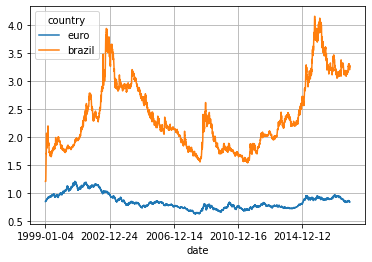

In [17]:
df_wide[["euro", "brazil"]].plot()
plt.grid()

Computing daily log-returns for each currency rate.

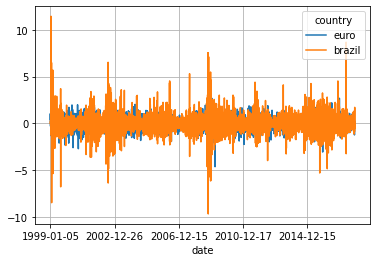

In [19]:
df_ret = np.log(df_wide).diff().dropna() * 100
df_ret[["euro", "brazil"]].plot()
plt.grid()

## Univariate data

We are only going to look at the "euro" exchange rate returns for univariate analysis; below we will then revisit a multivariate analysis.

In [20]:
from torchlambertw.utils import plot as twplt

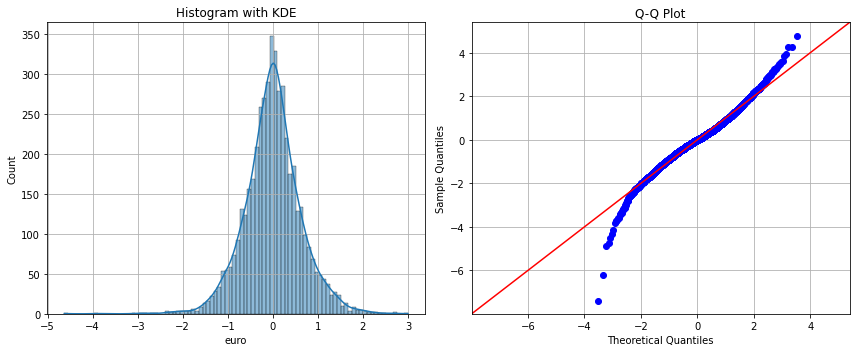

In [22]:
twplt.test_norm(df_ret["euro"])

In [25]:
from torchlambertw.models import igmm
from torchlambertw.preprocessing import gaussianizing

mod = igmm.IGMM()
mod.fit(df_ret["euro"])
mod.params_

Tau(loc=array([-0.00012052]), scale=array([0.53003691]), lambertw_params=LambertWParams(gamma=array([0.]), delta=array([0.10140151]), alpha=array([1.])))

In [32]:
clf = gaussianizing.Gaussianizer(lambertw_type="h", method="igmm")
clf.fit(df_ret["euro"])


/home/georg/Projects/torchlambertw/torchlambertw/preprocessing/gaussianizing.py:47: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data = data[:, np.newaxis]
100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


In [33]:
clf.estimators

[IGMM(lambertw_type=<LambertWType.H: 'h'>)]

In [34]:
x = clf.transform(df_ret["euro"])

/home/georg/Projects/torchlambertw/torchlambertw/preprocessing/gaussianizing.py:76: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data = data[:, np.newaxis]


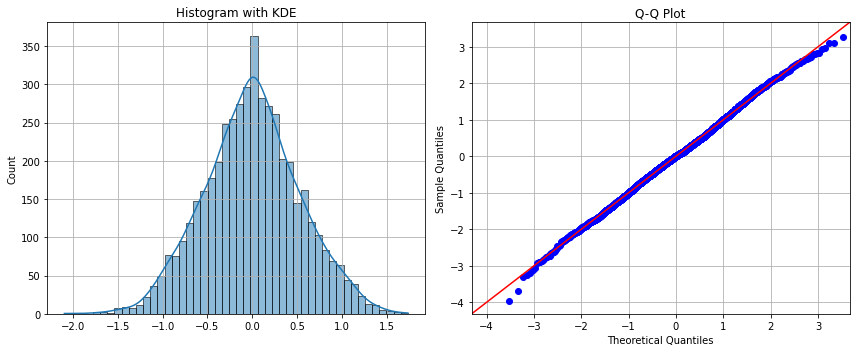

In [35]:
twplt.test_norm(x)

## Multivariate data

For the multivariate analysis and Gaussianization we are looking at all 22 rates overall, and then check in particular the (Euro, Brazil, US) dependencies.

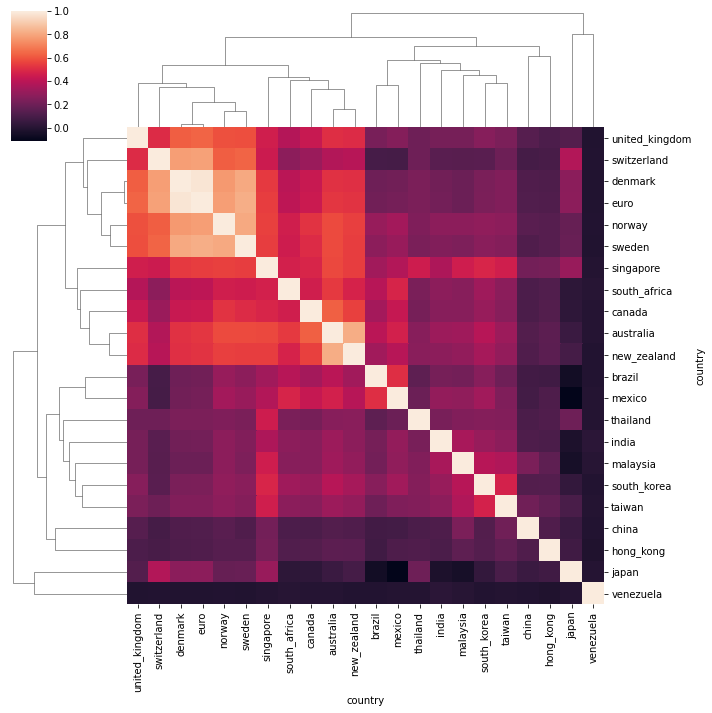

In [37]:
sns.clustermap(df_ret.corr())

<AxesSubplot:ylabel='country'>

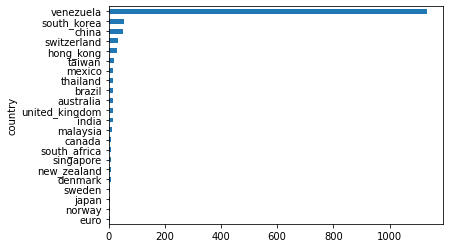

In [40]:
df_ret.apply(moments.kurtosis, axis=0).sort_values().plot.barh()

<AxesSubplot:xlabel='date'>

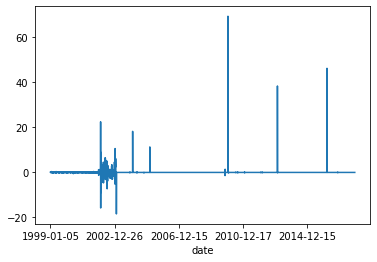

In [128]:
df_ret["venezuela"].plot()

Dropping `"venezuela"` as it has extended periods of exact 0. change and thus not a continous distribution.

In [41]:
df_ret = df_ret.drop("venezuela", axis=1)

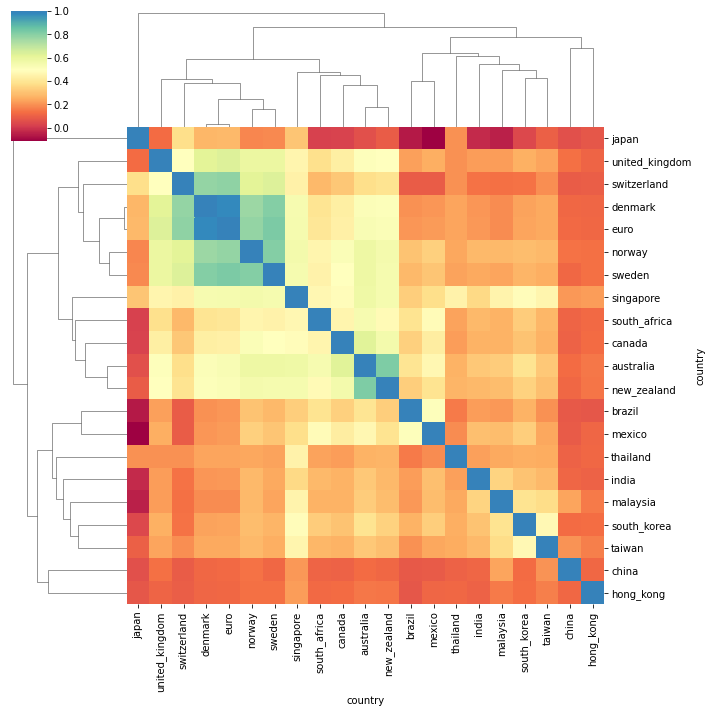

In [42]:
sns.clustermap(df_ret.corr(), cmap="Spectral", center=0.5)

<AxesSubplot:xlabel='date'>

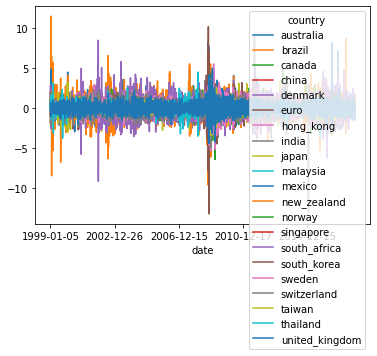

In [43]:
df_ret.plot()

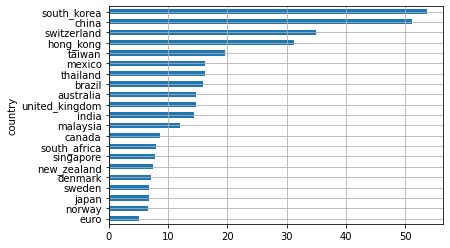

In [44]:
df_ret.apply(moments.kurtosis, axis=0).sort_values().plot.barh()
plt.grid()

In [45]:
clf = gaussianizing.Gaussianizer(lambertw_type="h", method="igmm")

In [46]:
clf.fit(df_ret)

100%|██████████| 21/21 [00:04<00:00,  4.98it/s]


In [47]:
clf.params

,loc,scale,delta
country,,,
australia,-0.013557,0.595112,0.164597
brazil,0.010242,0.697263,0.229400
canada,-0.004303,0.435170,0.149713
china,-0.002830,0.030972,0.638387
denmark,0.000282,0.521806,0.117920
euro,-0.000121,0.530037,0.101402
hong_kong,0.000592,0.011375,0.483632
india,0.003831,0.239700,0.317584
japan,0.003209,0.523155,0.134030


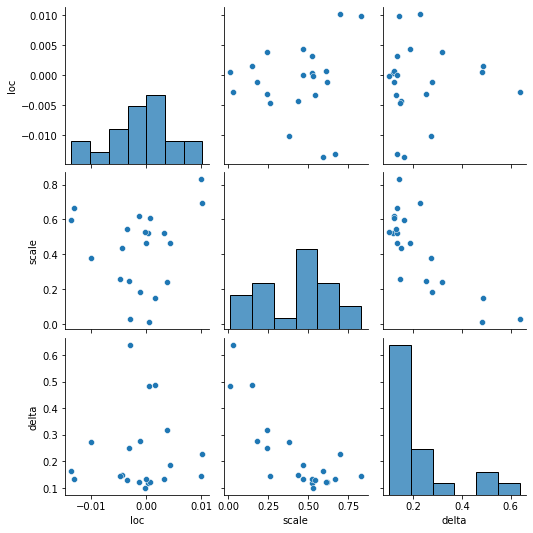

In [48]:
sns.pairplot(clf.params)

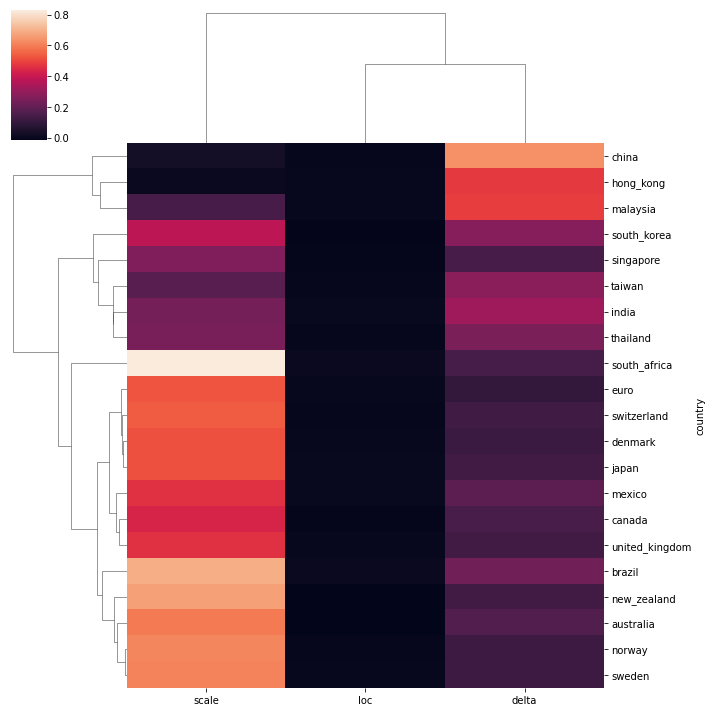

In [49]:
sns.clustermap(clf.params)

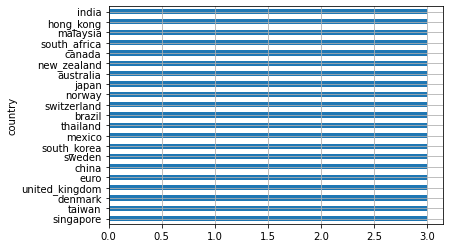

In [55]:
df_ret_gauss = clf.transform(df_ret)
df_ret_gauss.apply(moments.kurtosis, axis=0).sort_values().plot.barh()
plt.grid()

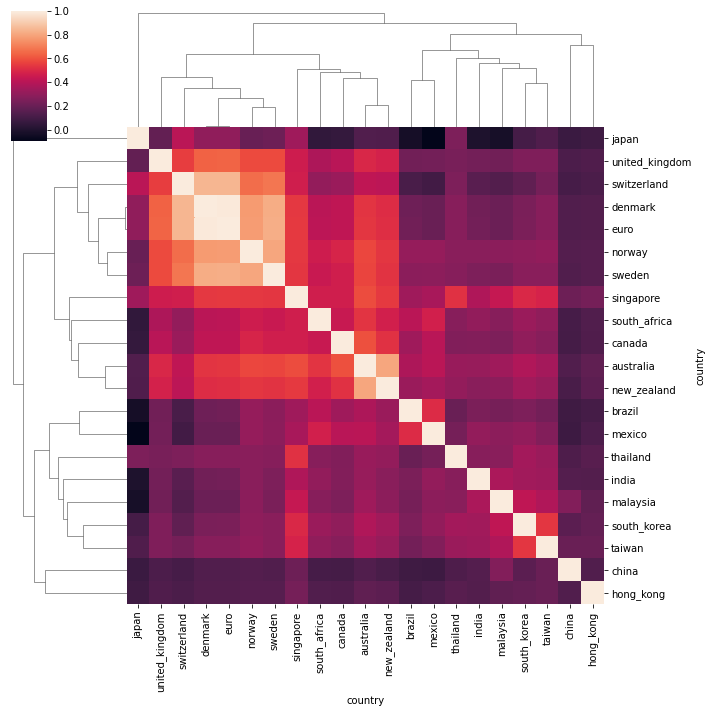

In [51]:
sns.clustermap(df_ret_gauss.corr())

<AxesSubplot:xlabel='date'>

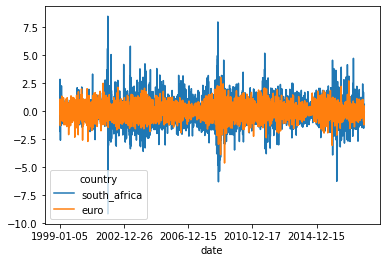

In [123]:
selected = ["south_africa", "euro"]
df_ret[selected].plot()

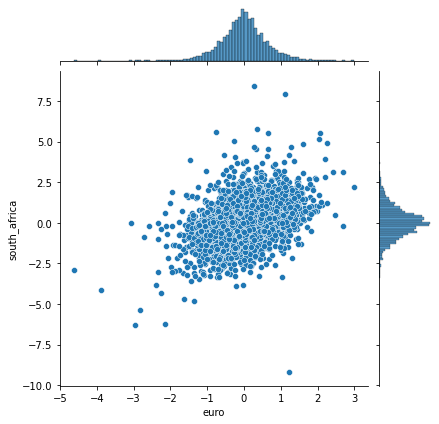

In [125]:
sns.jointplot(data=df_ret[selected], x="euro", y="south_africa")

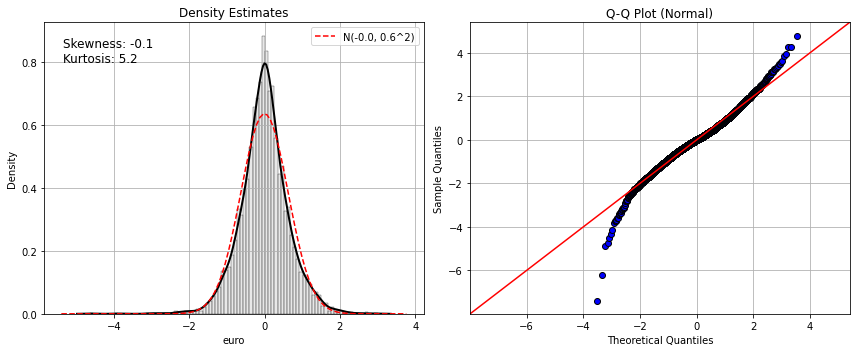

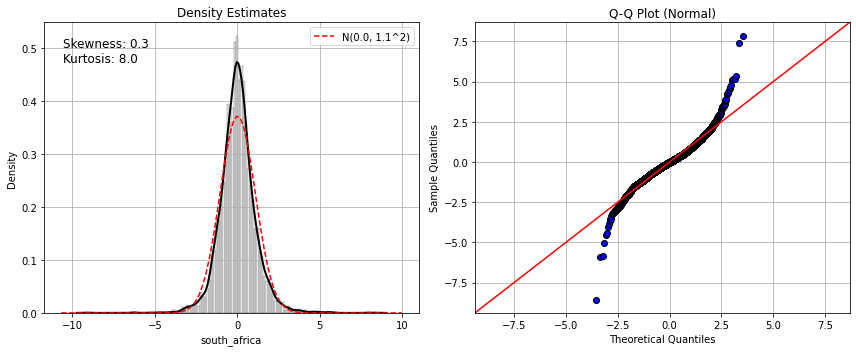

In [126]:
plot.test_norm(df_ret["euro"])
plot.test_norm(df_ret["south_africa"])

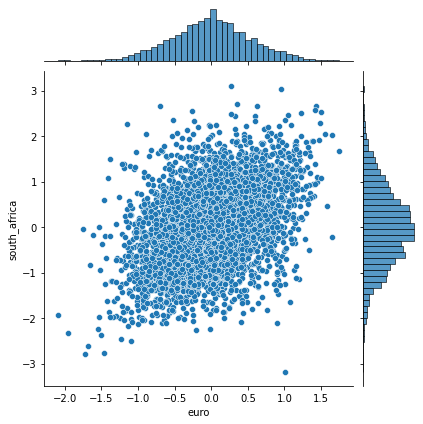

In [127]:
sns.jointplot(data=df_ret_gauss[selected], x="euro", y="south_africa")


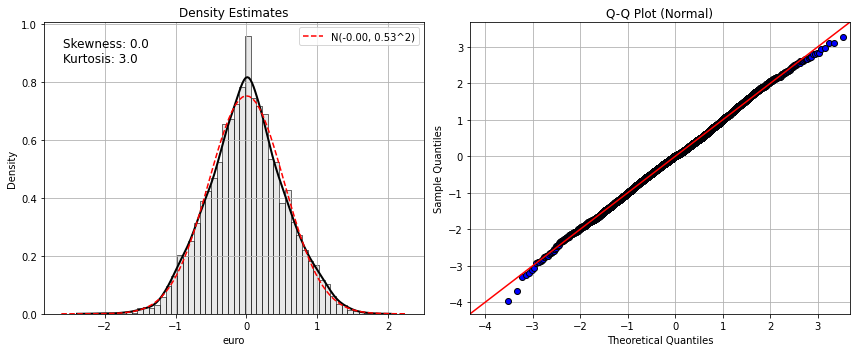

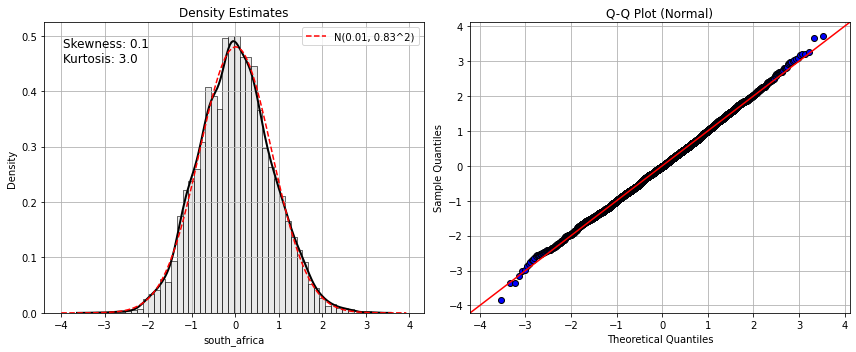

In [129]:
plot.test_norm(df_ret_gauss["euro"])
plot.test_norm(df_ret_gauss["south_africa"])

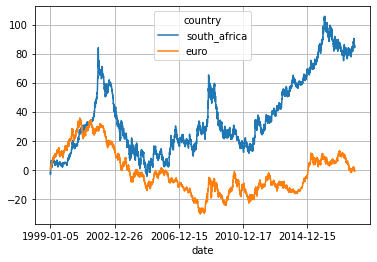

In [130]:
df_ret[selected].cumsum().plot()
plt.grid()